# Assignment 04 : Transformers

### Team: Pretrained Prodigies

#### Members:

- Rakshit Gupta (A00463237)
- Raoof Noushad (A00476511)
- Tejasvi Bhutiyal (A00463485)


# Section 1: Transformer Architecture

<img src= https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png width= 500>


In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

### Embedding

> The Embedding class defined is used for converting input tokens (integers) into vectors of a specified dimension. This is a critical step, as it allows for the representation of discrete elements (like words or, in our case integers) in a continuous, high-dimensional space.

> Shape of input: [batch_size, sequence_length]

> Shape of output: [batch_size, sequence_length, embed_dim]


In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

Code to get the information on shapes of the above class


In [ ]:
vocab_size = 10
embed_dim = 4

embedding_layer = Embedding(vocab_size, embed_dim)

batch_size = 1
sequence_length = 5
sample_input = torch.tensor([[7, 8, 9, 1, 6]])


output_embeddings = embedding_layer(sample_input)
print("output_embeddings: ", output_embeddings)
print("Input Shape:", sample_input.shape)
print("Output Shape:", output_embeddings.shape)

output_embeddings:  tensor([[[-1.1113e-01,  2.0475e-01, -1.6002e-01, -2.0407e-01],
         [-2.1972e+00,  1.5732e+00, -1.1697e+00, -3.2185e-01],
         [-6.0889e-01,  8.4548e-01,  4.9983e-01,  6.5495e-01],
         [-3.7647e-01,  1.8573e-01,  6.2652e-01, -3.2394e-01],
         [ 1.2667e-03,  5.1968e-01,  1.0160e+00,  8.2725e-01]]],
       grad_fn=<EmbeddingBackward0>)
Input Shape: torch.Size([1, 5])
Output Shape: torch.Size([1, 5, 4])


### Positional Encoding

> The Positional Embedding class is designed to add positional information to embeddings created by Embedding class in our Transformer model. Positinal embedding will generate a matrix of similar to embedding matrix. It will create a matrix of dimension sequence length x embedding dimension. For each token(word) in sequence, we will find the embedding vector which is of dimension 1 x embedding dimension and it is added with the correspondng positional vector which is of dimension 1 x embedding dimension to get 1 x embedding dimension dim out for each word/token.

> Shape of input: [batch_size, sequence_length, embed_dim]

> Shape of output: [batch_size, sequence_length, embed_model_dim]


In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / self.embed_dim)))
                pe[pos, i + 1] = math.cos(
                    pos / (10000 ** ((2 * (i + 1)) / self.embed_dim))
                )
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """

        x = x * math.sqrt(self.embed_dim)
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:, :seq_len], requires_grad=False)
        return x

Code to get the information on shapes of the above class


In [ ]:
max_seq_len = 5
embed_model_dim = 4

pos_embedding = PositionalEmbedding(max_seq_len, embed_model_dim)


output_with_pos = pos_embedding(output_embeddings)

# output embeddings created from embedding class in the code above
print("pe: ", pos_embedding.pe)
print("Input Shape:", output_embeddings.shape)
print("Output Shape:", output_with_pos.shape)

pe:  tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  9.9995e-01,  1.0000e-04,  1.0000e+00],
         [ 9.0930e-01,  9.9980e-01,  2.0000e-04,  1.0000e+00],
         [ 1.4112e-01,  9.9955e-01,  3.0000e-04,  1.0000e+00],
         [-7.5680e-01,  9.9920e-01,  4.0000e-04,  1.0000e+00]]])
Input Shape: torch.Size([1, 5, 4])
Output Shape: torch.Size([1, 5, 4])


##


## Attention

###-Self Attention
Imagine you have a sentence made up of several words. Self-attention is like a spotlight that each word shines on the other words in the sentence, figuring out how much attention or importance each word should give to the others.
Each Word Has Three Jobs:

Every word in the sentence has three tasks: it acts as a spotlight (key), it looks around to see what's important (query), and it decides how much it wants to share (value).

Now, each word compares itself to all the other words in the sentence. It checks how important each word is to it.

The comparison results in attention scores, kind of like ratings. Each word gets a score for how much attention it should give to every other word.

For example, in the sentence: “The cat is on the mat. It ate a lot of food”, “It” refers to the cat, and not the mat, so the attention mechanism will weigh the token “cat” in the processing of token “It”.

###-Mutlti Head Attention
<img src= https://miro.medium.com/v2/resize:fit:1400/format:webp/0*--TCGWYxwASbv2ra.png width = 500>
<br>

Multi-head attention allows the model to focus on different parts of the input sequence differently and learn different types of relationships or patterns simultaneously.

In a standard attention mechanism, you compute a weighted sum of values (V) based on the attention scores (computed from queries (Q) and keys (K)) to obtain an output. Multi-head attention extends this idea by performing attention multiple times in parallel, with different sets of learnable parameters for each "head." The outputs from these multiple attention heads are then concatenated and linearly transformed to produce the final output.


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        # 512 dim
        self.embed_dim = embed_dim
        # 8
        self.n_heads = n_heads
        # 512/8 = 64  . each key,query, value will be of 64d
        self.single_head_dim = int(self.embed_dim / self.n_heads)

        # key,query and value matrixes    #64 x 64
        # The linear layers for all key, query, value will take 64 input and will return 64 output
        self.query_matrix = nn.Linear(
            self.single_head_dim, self.single_head_dim, bias=False
        )
        self.key_matrix = nn.Linear(
            self.single_head_dim, self.single_head_dim, bias=False
        )
        self.value_matrix = nn.Linear(
            self.single_head_dim, self.single_head_dim, bias=False
        )
        self.out = nn.Linear(self.n_heads * self.single_head_dim, self.embed_dim)

    # batch_size x sequence_length x embedding_dim    input: 32 x 10 x 512
    def forward(self, key, query, value, mask=None):
        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        # provide the batch size
        batch_size = key.size(0)
        # provide the max sequence length
        seq_length = key.size(1)

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        seq_length_query = query.size(1)

        # batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)
        query = query.view(
            batch_size, seq_length_query, self.n_heads, self.single_head_dim
        )
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)

        # 32x10x8x64
        k = self.key_matrix(key)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        # 32 x 8 x 10 x 64
        # (batch_size, n_heads, seq_len, single_head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # computes attention
        # adjust key for matrix multiplication
        # batch_size, n_heads, single_head_dim, seq_ken = 32 x 8 x 64 x 10
        k_adjusted = k.transpose(-1, -2)

        # (32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = 32 x 8 x 10 x 10
        product = torch.matmul(q, k_adjusted)

        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))

        # divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim)
        # applying softmax
        scores = F.softmax(product, dim=-1)

        # mutiply with value matrix
        scores = torch.matmul(scores, v)

        # concatenated output
        # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
        concat = (
            scores.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length_query, self.single_head_dim * self.n_heads)
        )

        # (32,10,512)
        output = self.out(concat)

        return output

In [ ]:
batch_size = 2
sequence_length = 6
embedding_dim = 30

# Create random tensors
key = torch.randn(batch_size, sequence_length, embedding_dim)
value = torch.randn(batch_size, sequence_length, embedding_dim)
query = torch.randn(batch_size, sequence_length, embedding_dim)

# Print the sizes of the tensors
print("Size of key tensor:", key.size())
print("Size of value tensor:", value.size())
print("Size of query tensor:", query.size())

attention = MultiHeadAttention(n_heads=2, embed_dim=embedding_dim)
output = attention(key, query, value)
print("MultiHeadAttention Output Shape: ", output.size())

Size of key tensor: torch.Size([2, 6, 30])
Size of value tensor: torch.Size([2, 6, 30])
Size of query tensor: torch.Size([2, 6, 30])
MultiHeadAttention Output Shape:  torch.Size([2, 6, 30])


#Encoder
The EncoderLayer class initializes with input parameters and components, including a MultiHeadAttention module, a PositionWiseFeedForward module, two layer normalization modules, and a dropout layer. The forward methods computes the encoder layer output by applying self-attention, adding the attention output to the input tensor, and normalizing the result. Then, it computes the position-wise feed-forward output, combines it with the normalized self-attention output, and normalizes the final result before returning the processed tensor.
<img src= https://miro.medium.com/v2/resize:fit:552/format:webp/0*bPKV4ekQr9ZjYkWJ.png >


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8, dropout=0.2):
        super(TransformerBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, expansion_factor * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion_factor * embed_dim, embed_dim),
        )

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, key, query, value):
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block

        """

        attention_out = self.attention(key, query, value)
        attention_residual_out = attention_out + value
        norm1_out = self.dropout1(self.norm1(attention_residual_out))

        feed_fwd_out = self.feed_forward(norm1_out)
        feed_fwd_residual_out = feed_fwd_out + norm1_out
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out))

        return norm2_out


class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention

    Returns:
        out: output of the encoder
    """

    def __init__(
        self,
        seq_len,
        vocab_size,
        embed_dim,
        num_layers=2,
        expansion_factor=4,
        n_heads=8,
        dropout=0.2,
    ):
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_dim, expansion_factor, n_heads)
                for i in range(num_layers)
            ]
        )

        # added extra layer on top of encoder for our task
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out, out, out)

        out = self.output_layer(out)
        return out

# Decoder

The DecoderLayer initializes with input parameters and components such as MultiHeadAttention modules for masked self-attention and cross-attention, a PositionWiseFeedForward module, three layer normalization modules, and a dropout layer.

The forward method computes the decoder layer output by performing the following steps:

1.  Calculate the masked self-attention output and add it to the input tensor, followed by dropout and layer normalization.

2.  Compute the cross-attention output between the decoder and encoder outputs, and add it to the normalized masked self-attention output, followed by dropout and layer normalization.

3.  Calculate the position-wise feed-forward output and combine it with the normalized cross-attention output, followed by dropout and layer normalization.
4.  Return the processed tensor.

These operations enable the decoder to generate target sequences based on the input and the encoder output.

<img src= https://miro.medium.com/v2/resize:fit:552/format:webp/0*SPZgT4k8GQi37H__.png>


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)

    def forward(self, key, query, x, mask):
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention
        Returns:
           out: output of transformer block

        """

        # we need to pass mask mask only to fst attention
        attention = self.attention(x, x, x, mask=mask)  # 32x10x512
        value = self.dropout(self.norm(attention + x))

        out = self.transformer_block(key, query, value)

        return out

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        target_vocab_size,
        embed_dim,
        seq_len,
        num_layers=2,
        expansion_factor=4,
        n_heads=8,
    ):
        super(TransformerDecoder, self).__init__()
        """
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):
        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """

        x = self.word_embedding(x)
        x = self.position_embedding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)

        out = F.softmax(self.fc_out(x))

        return out

Code to get the information on shapes of the above class


In [ ]:
# Parameters for testing
target_vocab_size = 1000
embed_dim = 512
seq_len = 10
num_layers = 2
expansion_factor = 4
n_heads = 8

decoder = TransformerDecoder(
    target_vocab_size, embed_dim, seq_len, num_layers, expansion_factor, n_heads
)

batch_size = 32

# size of x = 32 X 1O
x = torch.randint(0, target_vocab_size, (batch_size, seq_len))

# size of enc_out = 32 X 1O X 512
enc_out = torch.rand(batch_size, seq_len, embed_dim)

mask = torch.ones(batch_size, 1, seq_len, seq_len)

out = decoder(x, enc_out, mask)

# Print the shape of the output tensor
print("TransformerDecoder Output Shape:", out.shape)

TransformerDecoder Output Shape: torch.Size([32, 10, 1000])


<ipython-input-10-d30d351e0417>:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc_out(x))


# Section 2: Model Building for Reversing List Of Integers
## Data Flow in the code
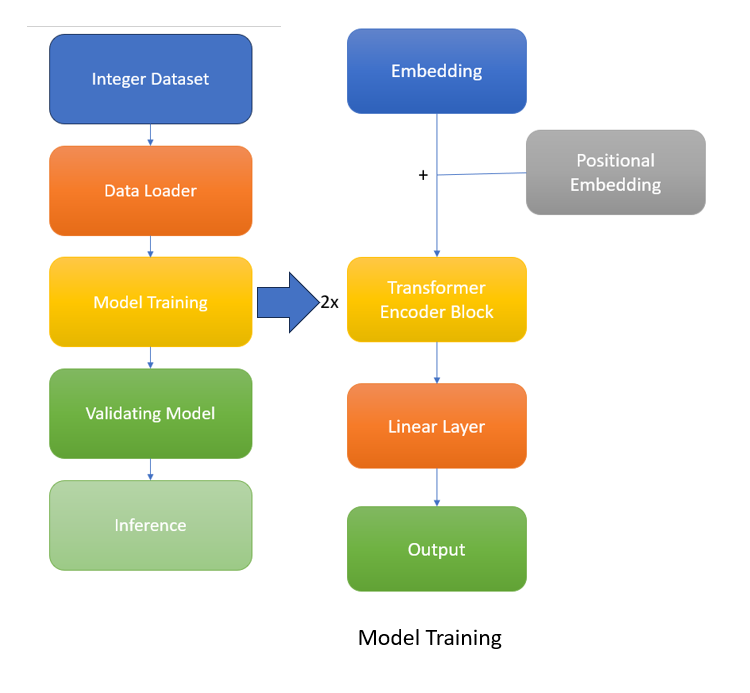


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data.dataset import random_split
from tqdm import tqdm

##Creating dataset for reversing list of Integers
The purpose of this class is to generate a dataset where each item is a pair of sequences: the original sequence of integers and its reversed version, both padded to a fixed length.


In [ ]:
class IntegerReverseDataset(Dataset):
    def __init__(self, num_samples=1000, max_length=5):
        self.data = []
        while len(self.data) < num_samples:
            # generate random length of sequence
            length = torch.randint(3, max_length + 1, (1,)).item()

            # generate sequence of random length
            sequence = torch.randint(1, 10, (length,)).tolist()

            reversed_sequence = list(reversed(sequence)) + [0] * (max_length - length)
            sequence += [0] * (max_length - length)
            # reversed_sequence = list(reversed(sequence))
            if (sequence, reversed_sequence) not in self.data:
                self.data.append((sequence, reversed_sequence))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0]), torch.tensor(self.data[idx][1])

##Training


In [ ]:
def train(
    model,
    train_data_loader,
    val_data_loader,
    device="cpu",
    epochs=100,
    lr=0.001,
    patience=3,
    vocab_size=10,
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="mean")

    best_val_loss = np.inf
    patience_count = 0

    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses

    model.train()
    for epoch in range(epochs):
        total_loss = 0

        # Training loop
        for seq, target in tqdm(
            train_data_loader, desc=f"Epoch {epoch + 1} (Training)"
        ):
            optimizer.zero_grad()
            output = model(seq.to(device))
            loss = criterion(
                output.view(-1, output.size(-1)), target.to(device).view(-1)
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Calculate and print the average training loss for the epoch
        average_train_loss = total_loss / len(train_data_loader)
        print(f"Epoch {epoch + 1} (Training), Loss: {average_train_loss:.4f}")
        train_losses.append(average_train_loss)  # Append training loss for plotting

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0

            for val_seq, val_target in val_data_loader:
                val_output = model(val_seq.to(device))
                val_loss += criterion(
                    val_output.view(-1, vocab_size), val_target.to(device).view(-1)
                ).item()

        # Calculate and print the average validation loss for the epoch
        average_val_loss = val_loss / len(val_data_loader)
        print(f"Epoch {epoch + 1} (Validation), Loss: {average_val_loss:.4f}")
        val_losses.append(average_val_loss)  # Append validation loss for plotting

        # Check for early stopping
        # if average_val_loss < best_val_loss:
        #     best_val_loss = average_val_loss
        #     patience_count = 0
        # else:
        #     patience_count += 1
        #     if patience_count >= patience:
        #         print(f"Early stopping after {patience} epochs without improvement.")
        #         break

    return train_losses, val_losses

In [ ]:
# Variables
num_samples = 10000
max_seq_length = 5
t_size = 0.8
vocab_size = 10
device = "cuda"
batch_size = 64
epochs = 50

In [ ]:
# Earlier variables
embed_dim = 512
num_layers = 2
expansion_factor = 4
n_heads = 8
dropout = 0.2

In [ ]:
# Optimzed variables
optimized_embed_dim = 32
optimized_num_layers = 2
optimized_expansion_factor = 4
optimized_n_heads = 4
optimized_dropout = 0.2

In [ ]:
# Create a dataset of integer sequences and their reversals
full_dataset = IntegerReverseDataset(num_samples=num_samples, max_length=max_seq_length)

# Calculate the size of the training dataset and remaining dataset
train_size = int(t_size * len(full_dataset))
rem_size = len(full_dataset) - train_size

# Splitting the data into training dataset and remaing dataset
train_dataset, rem_dataset = random_split(full_dataset, [train_size, rem_size])

# Splitting the remaing dataset into validation dataset and test dataset
val_dataset, test_dataset = random_split(rem_dataset, [rem_size // 2, rem_size // 2])

# Creating data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Size of Train Loader: {len(train_loader.dataset)}")
print(f"Size of Validation Loader: {len(val_loader.dataset)}")
print(f"Size of Test Loader: {len(test_loader.dataset)}")

Size of Train Loader: 8000
Size of Validation Loader: 1000
Size of Test Loader: 1000


In [ ]:
model = TransformerEncoder(
    seq_len=max_seq_length,
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    expansion_factor=expansion_factor,
    n_heads=n_heads,
    dropout=dropout,
)
optimized_model = TransformerEncoder(
    seq_len=max_seq_length,
    vocab_size=vocab_size,
    embed_dim=optimized_embed_dim,
    num_layers=optimized_num_layers,
    expansion_factor=optimized_expansion_factor,
    n_heads=optimized_n_heads,
    dropout=optimized_dropout,
)

model = model.to(device)
optimized_model = optimized_model.to(device)

for name, layer in model.named_children():
    print(f"Layer: {name}\n{layer}")
    print("=" * 50)

Layer: embedding_layer
Embedding(
  (embed): Embedding(10, 512)
)
Layer: positional_encoder
PositionalEmbedding()
Layer: layers
ModuleList(
  (0-1): 2 x TransformerBlock(
    (attention): MultiHeadAttention(
      (query_matrix): Linear(in_features=64, out_features=64, bias=False)
      (key_matrix): Linear(in_features=64, out_features=64, bias=False)
      (value_matrix): Linear(in_features=64, out_features=64, bias=False)
      (out): Linear(in_features=512, out_features=512, bias=True)
    )
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (feed_forward): Sequential(
      (0): Linear(in_features=512, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=512, bias=True)
    )
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
)
Layer: output_layer
Linear(in_features=512, out_features=10, bias=True)


In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, device, epochs)
train_losses_optimized, val_losses_optimized = train(
    optimized_model, train_loader, val_loader, device, epochs
)
torch.save(model.state_dict(), "model_ass4.pth")

Epoch 1 (Training): 100%|██████████| 125/125 [00:01<00:00, 117.12it/s]


Epoch 1 (Training), Loss: 1.3142
Epoch 1 (Validation), Loss: 1.1559


Epoch 2 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.51it/s]


Epoch 2 (Training), Loss: 1.1180
Epoch 2 (Validation), Loss: 1.1166


Epoch 3 (Training): 100%|██████████| 125/125 [00:00<00:00, 128.76it/s]


Epoch 3 (Training), Loss: 1.0998
Epoch 3 (Validation), Loss: 1.1027


Epoch 4 (Training): 100%|██████████| 125/125 [00:00<00:00, 131.53it/s]


Epoch 4 (Training), Loss: 1.0873
Epoch 4 (Validation), Loss: 1.0941


Epoch 5 (Training): 100%|██████████| 125/125 [00:00<00:00, 129.80it/s]


Epoch 5 (Training), Loss: 1.0801
Epoch 5 (Validation), Loss: 1.0919


Epoch 6 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.19it/s]


Epoch 6 (Training), Loss: 1.0747
Epoch 6 (Validation), Loss: 1.0883


Epoch 7 (Training): 100%|██████████| 125/125 [00:00<00:00, 127.70it/s]


Epoch 7 (Training), Loss: 1.0721
Epoch 7 (Validation), Loss: 1.0892


Epoch 8 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.48it/s]


Epoch 8 (Training), Loss: 1.0690
Epoch 8 (Validation), Loss: 1.0893


Epoch 9 (Training): 100%|██████████| 125/125 [00:01<00:00, 110.50it/s]


Epoch 9 (Training), Loss: 1.0648
Epoch 9 (Validation), Loss: 1.0864


Epoch 10 (Training): 100%|██████████| 125/125 [00:01<00:00, 98.83it/s] 


Epoch 10 (Training), Loss: 1.0644
Epoch 10 (Validation), Loss: 1.0883


Epoch 11 (Training): 100%|██████████| 125/125 [00:01<00:00, 98.68it/s] 


Epoch 11 (Training), Loss: 1.0636
Epoch 11 (Validation), Loss: 1.0886


Epoch 12 (Training): 100%|██████████| 125/125 [00:01<00:00, 107.65it/s]


Epoch 12 (Training), Loss: 1.0612
Epoch 12 (Validation), Loss: 1.0887


Epoch 13 (Training): 100%|██████████| 125/125 [00:00<00:00, 127.46it/s]


Epoch 13 (Training), Loss: 1.0583
Epoch 13 (Validation), Loss: 1.0876


Epoch 14 (Training): 100%|██████████| 125/125 [00:00<00:00, 128.95it/s]


Epoch 14 (Training), Loss: 1.0583
Epoch 14 (Validation), Loss: 1.0838


Epoch 15 (Training): 100%|██████████| 125/125 [00:01<00:00, 71.81it/s]


Epoch 15 (Training), Loss: 1.0569
Epoch 15 (Validation), Loss: 1.0948


Epoch 16 (Training): 100%|██████████| 125/125 [00:02<00:00, 57.89it/s]


Epoch 16 (Training), Loss: 1.0546
Epoch 16 (Validation), Loss: 1.0932


Epoch 17 (Training): 100%|██████████| 125/125 [00:01<00:00, 90.47it/s]


Epoch 17 (Training), Loss: 1.0549
Epoch 17 (Validation), Loss: 1.0890


Epoch 18 (Training): 100%|██████████| 125/125 [00:02<00:00, 47.51it/s]


Epoch 18 (Training), Loss: 1.0529
Epoch 18 (Validation), Loss: 1.0864


Epoch 19 (Training): 100%|██████████| 125/125 [00:02<00:00, 57.41it/s]


Epoch 19 (Training), Loss: 1.0511
Epoch 19 (Validation), Loss: 1.0938


Epoch 20 (Training): 100%|██████████| 125/125 [00:02<00:00, 57.99it/s]


Epoch 20 (Training), Loss: 1.0539
Epoch 20 (Validation), Loss: 1.0985


Epoch 21 (Training): 100%|██████████| 125/125 [00:01<00:00, 67.96it/s]


Epoch 21 (Training), Loss: 1.0500
Epoch 21 (Validation), Loss: 1.0916


Epoch 22 (Training): 100%|██████████| 125/125 [00:01<00:00, 65.99it/s]


Epoch 22 (Training), Loss: 1.0479
Epoch 22 (Validation), Loss: 1.0973


Epoch 23 (Training): 100%|██████████| 125/125 [00:01<00:00, 75.67it/s]


Epoch 23 (Training), Loss: 1.0480
Epoch 23 (Validation), Loss: 1.1035


Epoch 24 (Training): 100%|██████████| 125/125 [00:01<00:00, 66.32it/s]


Epoch 24 (Training), Loss: 1.0470
Epoch 24 (Validation), Loss: 1.0930


Epoch 25 (Training): 100%|██████████| 125/125 [00:01<00:00, 76.08it/s]


Epoch 25 (Training), Loss: 1.0433
Epoch 25 (Validation), Loss: 1.0999


Epoch 26 (Training): 100%|██████████| 125/125 [00:02<00:00, 52.81it/s]


Epoch 26 (Training), Loss: 1.0441
Epoch 26 (Validation), Loss: 1.1006


Epoch 27 (Training): 100%|██████████| 125/125 [00:01<00:00, 65.23it/s]


Epoch 27 (Training), Loss: 1.0426
Epoch 27 (Validation), Loss: 1.1091


Epoch 28 (Training): 100%|██████████| 125/125 [00:01<00:00, 76.16it/s]


Epoch 28 (Training), Loss: 1.0458
Epoch 28 (Validation), Loss: 1.1098


Epoch 29 (Training): 100%|██████████| 125/125 [00:01<00:00, 78.84it/s]


Epoch 29 (Training), Loss: 1.0666
Epoch 29 (Validation), Loss: 1.0844


Epoch 30 (Training): 100%|██████████| 125/125 [00:00<00:00, 130.63it/s]


Epoch 30 (Training), Loss: 1.0565
Epoch 30 (Validation), Loss: 1.0894


Epoch 31 (Training): 100%|██████████| 125/125 [00:01<00:00, 80.96it/s]


Epoch 31 (Training), Loss: 1.0511
Epoch 31 (Validation), Loss: 1.0887


Epoch 32 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.44it/s]


Epoch 32 (Training), Loss: 1.0480
Epoch 32 (Validation), Loss: 1.0969


Epoch 33 (Training): 100%|██████████| 125/125 [00:00<00:00, 125.54it/s]


Epoch 33 (Training), Loss: 1.0472
Epoch 33 (Validation), Loss: 1.0987


Epoch 34 (Training): 100%|██████████| 125/125 [00:00<00:00, 128.15it/s]


Epoch 34 (Training), Loss: 1.0450
Epoch 34 (Validation), Loss: 1.0997


Epoch 35 (Training): 100%|██████████| 125/125 [00:01<00:00, 95.95it/s]


Epoch 35 (Training), Loss: 1.0440
Epoch 35 (Validation), Loss: 1.0989


Epoch 36 (Training): 100%|██████████| 125/125 [00:01<00:00, 99.92it/s] 


Epoch 36 (Training), Loss: 1.0435
Epoch 36 (Validation), Loss: 1.0949


Epoch 37 (Training): 100%|██████████| 125/125 [00:01<00:00, 102.40it/s]


Epoch 37 (Training), Loss: 1.0411
Epoch 37 (Validation), Loss: 1.1038


Epoch 38 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.82it/s]


Epoch 38 (Training), Loss: 1.0395
Epoch 38 (Validation), Loss: 1.1091


Epoch 39 (Training): 100%|██████████| 125/125 [00:00<00:00, 128.16it/s]


Epoch 39 (Training), Loss: 1.0385
Epoch 39 (Validation), Loss: 1.1079


Epoch 40 (Training): 100%|██████████| 125/125 [00:00<00:00, 128.86it/s]


Epoch 40 (Training), Loss: 1.0360
Epoch 40 (Validation), Loss: 1.1108


Epoch 41 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.15it/s]


Epoch 41 (Training), Loss: 1.0356
Epoch 41 (Validation), Loss: 1.1104


Epoch 42 (Training): 100%|██████████| 125/125 [00:00<00:00, 130.70it/s]


Epoch 42 (Training), Loss: 1.0331
Epoch 42 (Validation), Loss: 1.1122


Epoch 43 (Training): 100%|██████████| 125/125 [00:00<00:00, 129.90it/s]


Epoch 43 (Training), Loss: 1.0338
Epoch 43 (Validation), Loss: 1.1235


Epoch 44 (Training): 100%|██████████| 125/125 [00:00<00:00, 128.64it/s]


Epoch 44 (Training), Loss: 1.0328
Epoch 44 (Validation), Loss: 1.1100


Epoch 45 (Training): 100%|██████████| 125/125 [00:00<00:00, 127.76it/s]


Epoch 45 (Training), Loss: 1.0308
Epoch 45 (Validation), Loss: 1.1151


Epoch 46 (Training): 100%|██████████| 125/125 [00:00<00:00, 125.86it/s]


Epoch 46 (Training), Loss: 1.0385
Epoch 46 (Validation), Loss: 1.1212


Epoch 47 (Training): 100%|██████████| 125/125 [00:01<00:00, 109.72it/s]


Epoch 47 (Training), Loss: 1.0329
Epoch 47 (Validation), Loss: 1.1092


Epoch 48 (Training): 100%|██████████| 125/125 [00:01<00:00, 97.78it/s]


Epoch 48 (Training), Loss: 1.0310
Epoch 48 (Validation), Loss: 1.1098


Epoch 49 (Training): 100%|██████████| 125/125 [00:01<00:00, 98.24it/s]


Epoch 49 (Training), Loss: 1.0287
Epoch 49 (Validation), Loss: 1.1172


Epoch 50 (Training): 100%|██████████| 125/125 [00:01<00:00, 113.66it/s]


Epoch 50 (Training), Loss: 1.0275
Epoch 50 (Validation), Loss: 1.1162


Epoch 1 (Training): 100%|██████████| 125/125 [00:00<00:00, 156.33it/s]


Epoch 1 (Training), Loss: 1.9646
Epoch 1 (Validation), Loss: 1.6019


Epoch 2 (Training): 100%|██████████| 125/125 [00:00<00:00, 164.48it/s]


Epoch 2 (Training), Loss: 1.3586
Epoch 2 (Validation), Loss: 1.2363


Epoch 3 (Training): 100%|██████████| 125/125 [00:00<00:00, 158.28it/s]


Epoch 3 (Training), Loss: 1.1921
Epoch 3 (Validation), Loss: 1.1850


Epoch 4 (Training): 100%|██████████| 125/125 [00:00<00:00, 161.98it/s]


Epoch 4 (Training), Loss: 1.1552
Epoch 4 (Validation), Loss: 1.1581


Epoch 5 (Training): 100%|██████████| 125/125 [00:00<00:00, 166.39it/s]


Epoch 5 (Training), Loss: 1.1327
Epoch 5 (Validation), Loss: 1.1504


Epoch 6 (Training): 100%|██████████| 125/125 [00:00<00:00, 165.04it/s]


Epoch 6 (Training), Loss: 1.1186
Epoch 6 (Validation), Loss: 1.1324


Epoch 7 (Training): 100%|██████████| 125/125 [00:00<00:00, 162.79it/s]


Epoch 7 (Training), Loss: 1.1076
Epoch 7 (Validation), Loss: 1.1306


Epoch 8 (Training): 100%|██████████| 125/125 [00:00<00:00, 162.79it/s]


Epoch 8 (Training), Loss: 1.0985
Epoch 8 (Validation), Loss: 1.1204


Epoch 9 (Training): 100%|██████████| 125/125 [00:00<00:00, 165.58it/s]


Epoch 9 (Training), Loss: 1.0922
Epoch 9 (Validation), Loss: 1.1143


Epoch 10 (Training): 100%|██████████| 125/125 [00:00<00:00, 166.87it/s]


Epoch 10 (Training), Loss: 1.0870
Epoch 10 (Validation), Loss: 1.1152


Epoch 11 (Training): 100%|██████████| 125/125 [00:00<00:00, 171.37it/s]


Epoch 11 (Training), Loss: 1.0827
Epoch 11 (Validation), Loss: 1.1086


Epoch 12 (Training): 100%|██████████| 125/125 [00:00<00:00, 127.70it/s]


Epoch 12 (Training), Loss: 1.0780
Epoch 12 (Validation), Loss: 1.1071


Epoch 13 (Training): 100%|██████████| 125/125 [00:01<00:00, 118.43it/s]


Epoch 13 (Training), Loss: 1.0748
Epoch 13 (Validation), Loss: 1.1047


Epoch 14 (Training): 100%|██████████| 125/125 [00:01<00:00, 117.82it/s]


Epoch 14 (Training), Loss: 1.0702
Epoch 14 (Validation), Loss: 1.1007


Epoch 15 (Training): 100%|██████████| 125/125 [00:00<00:00, 139.17it/s]


Epoch 15 (Training), Loss: 1.0663
Epoch 15 (Validation), Loss: 1.0980


Epoch 16 (Training): 100%|██████████| 125/125 [00:00<00:00, 164.88it/s]


Epoch 16 (Training), Loss: 1.0623
Epoch 16 (Validation), Loss: 1.0958


Epoch 17 (Training): 100%|██████████| 125/125 [00:00<00:00, 165.17it/s]


Epoch 17 (Training), Loss: 1.0581
Epoch 17 (Validation), Loss: 1.0934


Epoch 18 (Training): 100%|██████████| 125/125 [00:00<00:00, 159.84it/s]


Epoch 18 (Training), Loss: 1.0553
Epoch 18 (Validation), Loss: 1.0862


Epoch 19 (Training): 100%|██████████| 125/125 [00:00<00:00, 168.80it/s]


Epoch 19 (Training), Loss: 1.0518
Epoch 19 (Validation), Loss: 1.0901


Epoch 20 (Training): 100%|██████████| 125/125 [00:00<00:00, 163.36it/s]


Epoch 20 (Training), Loss: 1.0466
Epoch 20 (Validation), Loss: 1.0758


Epoch 21 (Training): 100%|██████████| 125/125 [00:00<00:00, 163.96it/s]


Epoch 21 (Training), Loss: 1.0430
Epoch 21 (Validation), Loss: 1.0794


Epoch 22 (Training): 100%|██████████| 125/125 [00:00<00:00, 171.71it/s]


Epoch 22 (Training), Loss: 1.0372
Epoch 22 (Validation), Loss: 1.0691


Epoch 23 (Training): 100%|██████████| 125/125 [00:00<00:00, 166.12it/s]


Epoch 23 (Training), Loss: 1.0307
Epoch 23 (Validation), Loss: 1.0627


Epoch 24 (Training): 100%|██████████| 125/125 [00:00<00:00, 171.00it/s]


Epoch 24 (Training), Loss: 1.0269
Epoch 24 (Validation), Loss: 1.0625


Epoch 25 (Training): 100%|██████████| 125/125 [00:00<00:00, 168.32it/s]


Epoch 25 (Training), Loss: 1.0196
Epoch 25 (Validation), Loss: 1.0585


Epoch 26 (Training): 100%|██████████| 125/125 [00:00<00:00, 166.07it/s]


Epoch 26 (Training), Loss: 1.0130
Epoch 26 (Validation), Loss: 1.0497


Epoch 27 (Training): 100%|██████████| 125/125 [00:00<00:00, 162.05it/s]


Epoch 27 (Training), Loss: 1.0064
Epoch 27 (Validation), Loss: 1.0430


Epoch 28 (Training): 100%|██████████| 125/125 [00:01<00:00, 113.98it/s]


Epoch 28 (Training), Loss: 1.0004
Epoch 28 (Validation), Loss: 1.0330


Epoch 29 (Training): 100%|██████████| 125/125 [00:01<00:00, 117.97it/s]


Epoch 29 (Training), Loss: 0.9942
Epoch 29 (Validation), Loss: 1.0362


Epoch 30 (Training): 100%|██████████| 125/125 [00:01<00:00, 118.98it/s]


Epoch 30 (Training), Loss: 0.9860
Epoch 30 (Validation), Loss: 1.0252


Epoch 31 (Training): 100%|██████████| 125/125 [00:00<00:00, 168.56it/s]


Epoch 31 (Training), Loss: 0.9760
Epoch 31 (Validation), Loss: 1.0147


Epoch 32 (Training): 100%|██████████| 125/125 [00:00<00:00, 164.56it/s]


Epoch 32 (Training), Loss: 0.9651
Epoch 32 (Validation), Loss: 1.0070


Epoch 33 (Training): 100%|██████████| 125/125 [00:00<00:00, 168.32it/s]


Epoch 33 (Training), Loss: 0.9439
Epoch 33 (Validation), Loss: 0.9665


Epoch 34 (Training): 100%|██████████| 125/125 [00:00<00:00, 166.83it/s]


Epoch 34 (Training), Loss: 0.8813
Epoch 34 (Validation), Loss: 0.8773


Epoch 35 (Training): 100%|██████████| 125/125 [00:00<00:00, 167.21it/s]


Epoch 35 (Training), Loss: 0.7598
Epoch 35 (Validation), Loss: 0.7097


Epoch 36 (Training): 100%|██████████| 125/125 [00:00<00:00, 170.48it/s]


Epoch 36 (Training), Loss: 0.6234
Epoch 36 (Validation), Loss: 0.5571


Epoch 37 (Training): 100%|██████████| 125/125 [00:00<00:00, 170.76it/s]


Epoch 37 (Training), Loss: 0.5016
Epoch 37 (Validation), Loss: 0.4815


Epoch 38 (Training): 100%|██████████| 125/125 [00:00<00:00, 164.25it/s]


Epoch 38 (Training), Loss: 0.4219
Epoch 38 (Validation), Loss: 0.3992


Epoch 39 (Training): 100%|██████████| 125/125 [00:00<00:00, 165.93it/s]


Epoch 39 (Training), Loss: 0.3495
Epoch 39 (Validation), Loss: 0.3715


Epoch 40 (Training): 100%|██████████| 125/125 [00:00<00:00, 170.81it/s]


Epoch 40 (Training), Loss: 0.2984
Epoch 40 (Validation), Loss: 0.2981


Epoch 41 (Training): 100%|██████████| 125/125 [00:00<00:00, 164.35it/s]


Epoch 41 (Training), Loss: 0.2652
Epoch 41 (Validation), Loss: 0.2634


Epoch 42 (Training): 100%|██████████| 125/125 [00:00<00:00, 168.14it/s]


Epoch 42 (Training), Loss: 0.2425
Epoch 42 (Validation), Loss: 0.2465


Epoch 43 (Training): 100%|██████████| 125/125 [00:00<00:00, 145.91it/s]


Epoch 43 (Training), Loss: 0.2205
Epoch 43 (Validation), Loss: 0.2307


Epoch 44 (Training): 100%|██████████| 125/125 [00:01<00:00, 117.51it/s]


Epoch 44 (Training), Loss: 0.2034
Epoch 44 (Validation), Loss: 0.2043


Epoch 45 (Training): 100%|██████████| 125/125 [00:01<00:00, 121.01it/s]


Epoch 45 (Training), Loss: 0.1813
Epoch 45 (Validation), Loss: 0.1804


Epoch 46 (Training): 100%|██████████| 125/125 [00:00<00:00, 126.10it/s]


Epoch 46 (Training), Loss: 0.1502
Epoch 46 (Validation), Loss: 0.1877


Epoch 47 (Training): 100%|██████████| 125/125 [00:00<00:00, 160.22it/s]


Epoch 47 (Training), Loss: 0.1422
Epoch 47 (Validation), Loss: 0.1323


Epoch 48 (Training): 100%|██████████| 125/125 [00:00<00:00, 163.00it/s]


Epoch 48 (Training), Loss: 0.1220
Epoch 48 (Validation), Loss: 0.1154


Epoch 49 (Training): 100%|██████████| 125/125 [00:00<00:00, 167.57it/s]


Epoch 49 (Training), Loss: 0.1156
Epoch 49 (Validation), Loss: 0.1701


Epoch 50 (Training): 100%|██████████| 125/125 [00:00<00:00, 157.01it/s]


Epoch 50 (Training), Loss: 0.1068
Epoch 50 (Validation), Loss: 0.0914


In [ ]:
# Plot training and validation losses
def plt_losses_graph(train_losses, val_losses, optimized=""):
    plt.figure(figsize=(8, 6))
    plt.plot(
        range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o"
    )
    plt.plot(
        range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title(f"Training and Validation Losses {optimized}")
    plt.show()

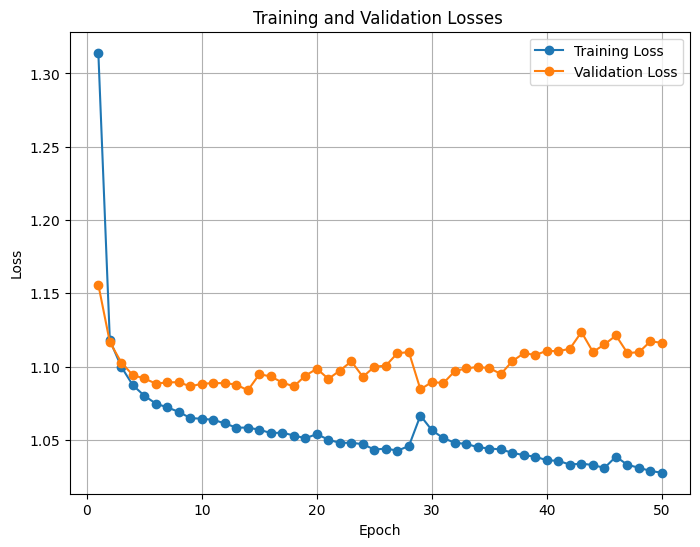

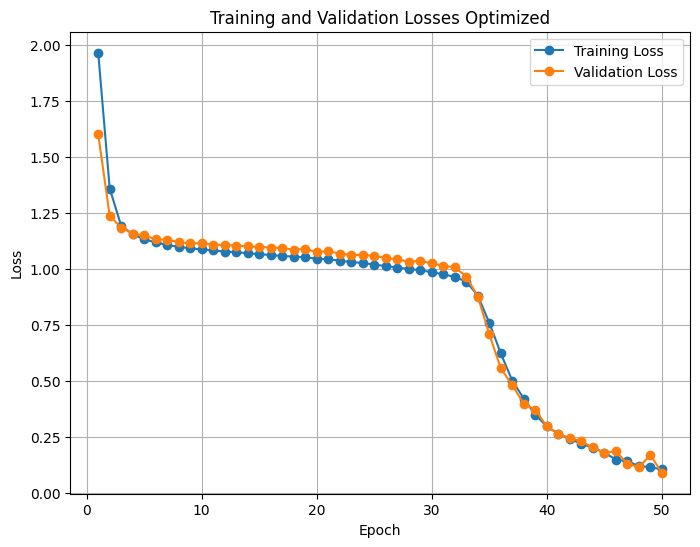

In [ ]:
# Optimized paramter
plt_losses_graph(train_losses, val_losses)
plt_losses_graph(train_losses_optimized, val_losses_optimized, "Optimized")

##Accuracy


In [ ]:
def calculate_accuracy(model, test_loader, device="cpu"):
    # Set the model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Get model predictions
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=2)

            # Calculate accuracy
            correct += (predicted == targets).sum().item()
            total += targets.numel()

    # print(total)
    accuracy = correct / total
    return accuracy


# Example usage:
accuracy = calculate_accuracy(model, test_loader, "cuda")
optimized_accuracy = calculate_accuracy(optimized_model, test_loader, "cuda")
print(f"Earlier Accuracy: {accuracy * 100:.2f}%")
print(f"Optimized Accuracy: {optimized_accuracy * 100:.2f}%")

Earlier Accuracy: 42.82%
Optimized Accuracy: 96.74%


# Inference


In [ ]:
def generate_output(model, sequence, device="cpu", max_length=5):
    sequence += [0] * (max_length - len(sequence))
    seq_tensor = (
        torch.tensor(sequence).unsqueeze(0).to(device)
    )  # Preallocate and move to device
    with torch.no_grad():
        output = model(seq_tensor)
        reversed_seq = [token for token in output.argmax(dim=-1).squeeze(0).tolist()]

    # Remove padding zeros from the reversed sequence
    reversed_seq = [token for token in reversed_seq if token != 0]

    return reversed_seq

In [ ]:
input_sequence = [5, 5, 3, 3, 1]
print("Input:", input_sequence)
output_sequence = generate_output(model, input_sequence, device)
print("Output:", output_sequence)

Input: [5, 5, 3, 3, 1]
Output: [1, 3, 3, 5, 5]


In [ ]:
# Results with optimized model
print("Input:", input_sequence)
output_sequence = generate_output(optimized_model, input_sequence, device)
print("Output:", output_sequence)

Input: [5, 5, 3, 3, 1]
Output: [1, 3, 3, 5, 5]


In [ ]:
input_sequence = [5, 2, 3]
print("Input:", input_sequence)
output_sequence = generate_output(model, input_sequence, device)
print("Output:", output_sequence)

Input: [5, 2, 3]
Output: [3, 3, 2]


In [ ]:
# Results with optimized model
input_sequence = [5, 2, 3]
print("Input:", input_sequence)
output_sequence = generate_output(optimized_model, input_sequence, device)
print("Output:", output_sequence)

Input: [5, 2, 3]
Output: [3, 2, 3]


In [ ]:
input_sequence = [4, 1, 3, 1]
print("Input:", input_sequence)
output_sequence = generate_output(model, input_sequence, device)
print("Output:", output_sequence)

Input: [4, 1, 3, 1]
Output: [1, 4, 1, 4]


In [ ]:
# Results with optimized model
input_sequence = [4, 1, 3, 1]
print("Input:", input_sequence)
output_sequence = generate_output(optimized_model, input_sequence, device)
print("Output:", output_sequence)

Input: [4, 1, 3, 1]
Output: [1, 3, 1, 4]


In [ ]:
input_sequence = [1, 7]
print("Input:", input_sequence)
output_sequence = generate_output(optimized_model, input_sequence, device)
print("Output:", output_sequence)

Input: [1, 7]
Output: [7, 1, 1]


In [ ]:
input_sequence = [3, 1, 1]
print("Input:", input_sequence)
output_sequence = generate_output(optimized_model, input_sequence, device)
print("Output:", output_sequence)

Input: [3, 1, 1]
Output: [1, 1, 1]


#Model Optimization for Reversed Sequence Generation
##Introduction
In the initial version of our model, we encountered difficulties in training it to accurately reverse sequences. The model did not converge effectively and showed signs of overfitting to the training data. In this report, we will discuss the changes made to improve the model's performance and how these adjustments positively impacted the results.<br>
##Initial Model Challenges

As shown in Graph 1, the initial model's training loss appeared to converge after a certain number of epochs. However, the validation loss continued to fluctuate and did not show signs of convergence. This behavior indicated that the model was struggling to generalize from the training data to unseen examples.
##Model Optimization Steps
To address the challenges faced by the initial model, several key hyperparameter and architecture adjustments were made:

1. Reducing Attention Heads
   The initial model employed eight attention heads, which proved to be excessive for the simplicity of the task. By reducing the number of attention heads to four, we aimed to simplify the model's complexity and help it focus on more relevant features.
2. Increasing Sample Size
   To enable the model to better understand the pattern of sequence reversal, we increased the sample size of the training dataset. This change provided the model with more diverse examples, enhancing its ability to generalize.
3. Reducing Embedding Dimension
   The embedding dimension of the initial model was set at 512, which might have been too high for this task. By reducing the embedding dimension to 32, we aimed to create a more compact representation of the input sequences, which could help the model capture essential features.
4. Padding Sequence
   Another crucial change was made to the dataset itself. We added padding to the sequences after reversing them. This padding ensured that all sequences had the same length, which simplified the model's learning process and enabled it to handle variable-length input more effectively.

##Improved Model Results

After implementing these changes, we observed significant improvements in the model's performance. The model started to converge effectively, as shown in Graph 2, where both the training and validation losses decrease steadily over time.<br>

##Conclusion
In conclusion, optimizing our model by reducing the number of attention heads, increasing the sample size, lowering the embedding dimension, and adding padding to the sequences after reversal led to significant improvements in its ability to reverse sequences accurately. These adjustments helped the model converge effectively and generalize better to unseen data. With these improvements, we can now confidently use the model to generate reversed sequences and evaluate its accuracy as previously discussed.
